#  Variational auto encoder
This notebook demonstrates a simple variational auto encoder. One should read the notebook on the simple auto encoder first.

## First I define some utility functions (unchaged from the auto encoder)
This functions can mostly be ignored and are included simply from necessity

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import typing
import utils

In [2]:
def visualize_model(encoder, decoder, X_val):
    val_size = X_val.shape[0]
    j = np.random.randint(0,val_size - 5)
    z = encode.forward(X_val)
    y = decode.forward(z)
    for i in range(0,5):
        plt.subplot(1,2,1)
        plt.imshow(X_val[j + i,1:].reshape(28,28), cmap="gray")
        plt.subplot(1,2,2)
        plt.imshow(y[j + i,1:].reshape(28,28), cmap="gray")
        plt.show()

In [3]:
def calculate_loss_l2(x, y):
    loss = np.sum(0.5*(x-y)**2)
    print(f"Validation l2 loss: {loss}")
    return loss

In [4]:
def calculate_KL_loss(mean, std):
    print(f"Mean: {np.mean(mean)}, std: {np.mean(std)}")
    KL_loss = 0.5*np.sum(mean**2 + std**2 - 1 - np.log(std+1e-4))
    print(f"Validation KL loss: {KL_loss}")
    return KL_loss

In [5]:
def pre_process_images(X: np.ndarray, mean: float = 33.3, std: float = 78.5):
    """
    Args:
        X: images of shape [batch size, 784] in the range (0, 255)
    Returns:
        X: images of shape [batch size, 785]
    """
    
    X = (X-mean)/std
    
    assert X.shape[1] == 784,\
        f"X.shape[1]: {X.shape[1]}, should be 784"
    
    newArr = np.ones((X.shape[0],785))
    newArr[:,1:] = X
    assert newArr.shape == (X.shape[0], 785),\
        f"Pre processed shape: {newArr.shape}"
    return newArr


## Model definitions
Here I define an encoder and a decoder. As they are both more or less identical FCNN I define a parent class and let both modules inherit from that class. 

### Base model

In [6]:
class Model:

    def __init__(self,
                 # Number of neurons per layer
                 neurons_per_layer: typing.List[int],
                 use_improved_sigmoid: bool,
                 use_improved_weight_init: bool  
                 ):
        # Define number of input nodes
        self.I = neurons_per_layer[0]
        self.use_improved_sigmoid = use_improved_sigmoid
        print(f"\n\nInitializing with improved sigmoid: {use_improved_sigmoid}")
        print(f"Initializing with improved weight init: {use_improved_weight_init}")

        self.neurons_per_layer = neurons_per_layer[1:]
        
        # Initialize the weights
        self.ws = []
        prev = self.I
        for size in self.neurons_per_layer:
            w_shape = (prev, size)
            print("Initializing weight to shape:", w_shape)
            if(use_improved_weight_init):
                w = np.random.normal(0, 1/np.sqrt(prev), w_shape)
            else:
                w = np.random.uniform(-1, 1, w_shape)
            self.ws.append(w)
            prev = size
        self.grads = [None for i in range(len(self.ws))]
        #Needed for backpropagation
        self.intermediates = []
        #Needed for improved sigmoid backpropagation
        self.z = []

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Args:
            X: images of shape [batch size, 785]
        Returns:
            y: output of model with shape [batch size, num_outputs]
        """

        assert X.shape[1] == self.ws[0].shape[0], \
            f"X shape: {X.shape}, weight shape: {self.ws[0].shape}"
        self.intermediates = []
        self.z = []
        self.intermediates.append(X)
        #Functionality for multiple layers for task 4c
        for i in range(0, len(self.ws)-1):
            self.z.append(self.intermediates[-1] @ self.ws[i])
            if(self.use_improved_sigmoid):
                self.intermediates.append(1.7159*np.tanh(2*self.z[-1]/3))
            else:
                self.intermediates.append(1/(1 + np.exp(- self.z[-1])))
        
        z2 = self.intermediates[-1] @ self.ws[-1] 
        #exponent = np.exp(z2)
        #exponent /= exponent.sum(axis = 1, keepdims = True)        
        #assert exponent.shape == (X.shape[0],10),\
         #   f"Shape after forward pass is wrong"
        return z2

    def backward(self, X: np.ndarray, delta):
        """
        Args:
            X: images of shape [batch size, 785]
            outputs: outputs of model of shape: [batch size, num_outputs]
            targets: labels/targets of each image of shape: [batch size, num_classes]
        """
        batchSize = X.shape[0]
        self.grads = []
        outputGrad = self.intermediates[-1].transpose() @ delta / batchSize
        self.grads.append(outputGrad)
        
        #Generalization to multiple layers
        for i in range(1,len(self.ws)):
            Q = delta @ self.ws[-i].transpose()
            if(self.use_improved_sigmoid):
                sigmoidDerivative = 2.28786/(np.cosh(4*self.z[-i]/3) + 1)
            else:
                sigmoidDerivative = (self.intermediates[-i]*(1-self.intermediates[-i]))
            delta = sigmoidDerivative * Q
            
            hiddenGrad = self.intermediates[-i-1].transpose() @ delta / batchSize
            self.grads.append(hiddenGrad)
            
        self.grads.reverse()
        Q = delta @ self.ws[0].transpose()   
        for grad, w in zip(self.grads, self.ws):
            assert grad.shape == w.shape,\
                f"Expected the same shape. Grad shape: {grad.shape}, w: {w.shape}."
        return Q

    def zero_grad(self) -> None:
        self.grads = [None for i in range(len(self.ws))]
        
    def update_weights(self, lr):
        for w, grad in zip(self.ws, self.grads):
            w -= lr*grad


### Decode model

The decode module is exactly the same as in the Auto-encoder.

In [7]:
class DecodeModel(Model):

    def __init__(self,
                 # Number of neurons per layer
                 neurons_per_layer: typing.List[int],
                 use_improved_sigmoid: bool,  # Task 3a hyperparameter
                 use_improved_weight_init: bool  # Task 3c hyperparameter
                 ):
        super().__init__(neurons_per_layer, use_improved_sigmoid, use_improved_weight_init)
    def backward(self, X: np.ndarray, outputs):
        """
        Args:
            X: images of shape [batch size, 785]
            outputs: Reconstructed images of shape [batch size, 785]
        """
        batchSize = X.shape[0]
        assert X.shape == outputs.shape,\
            f"Output shape: {outputs.shape}, targets: {X.shape}"
        # A list of gradients.
        # For example, self.grads[0] will be the gradient for the first hidden layer
        self.grads = []
        delta = (outputs - X)
        return super().backward(X, delta)

### Encode model

It is here in the encode module the difference between a VAE and an AE is evident. First of all, instead of predicting a latent space vector $\vec{z}$ directly, the module predicts a vector for the mean $\vec{\mu}$ and the standard deviation $\vec{\sigma}$.

With these two parameters one can calculate the latent space vector $\vec{z}$ by sampeling a stochastic variable $\epsilon$ from the standard normal distribution. The resulting latent space vector is thus calculated as follows $z = \mu + \sigma \epsilon$ 

In order for the model to follow a more or less normal distribution, a KL loss is introduced with a standard normal distribution as prior.
$$KL = \frac{1}{2} \sum{\sigma_i^2 + \mu_i^2 -1 - \log{\sigma}}$$


This would give the derivatives:

$$\frac{dC}{d \sigma_i} = \sigma_i - \frac{1}{2 \sigma_i}$$

and

$$\frac{dC}{d \mu_i} =  \mu_i$$


As the standard deviation must be positive, I use ReLU as activation function.

In [8]:
class EncodeModel(Model):
    def __init__(self,
                 # Number of neurons per layer
                 neurons_per_layer: typing.List[int],
                 use_improved_sigmoid: bool,  # Task 3a hyperparameter
                 use_improved_weight_init: bool  # Task 3c hyperparameter
                 ):
        super().__init__(neurons_per_layer[:-1], use_improved_sigmoid, use_improved_weight_init)
        prev = neurons_per_layer[-2]
        w_shape = (prev, neurons_per_layer[-1])
        self.output_size = neurons_per_layer[-1]
        if(use_improved_weight_init):
            print(f"Initializing weights with shape: {w_shape}")
            self.mean_w = np.random.normal(0, 1/np.sqrt(prev), w_shape)
            self.std_w = np.random.normal(0, 1/np.sqrt(prev), w_shape)
        else:
            self.mean_w = np.random.uniform(-1, 1, w_shape)
            self.std_w = np.random.uniform(-1, 1, w_shape)
    def forward(self, X):
        x = super().forward(X)
        self.intermediate_x = (1/(1 + np.exp(- x)))
        
        self.mean = self.intermediate_x @ self.mean_w
        self.std = self.intermediate_x @ self.std_w
        
        #Activation function
        self.std = np.maximum(0,self.std)
        #self.mean = 1/(1 + np.exp(-mean))
                 
        
        self.epsilon = np.random.normal(0,1, (self.output_size))
        
        return self.mean + self.std*self.epsilon
    def backward(self, X: np.ndarray, dZ: np.ndarray):
        dKL_dSTD = self.std - 1/(2*self.std + 1e-4)
        dKL_dMean = self.mean
        batch_size = X.shape[0]
        d_mean = dZ + dKL_dMean
        d_std = self.epsilon*dZ + dKL_dSTD
        
        #sigmoid_mean = self.mean*(1-self.mean)
        #d_mean = sigmoid_mean * d_mean
        
        #sigmoid_std = self.std*(1-self.std)
        #d_std = sigmoid_std*d_std
        d_std = np.where(self.std>0, 1,0)*d_std
        
        self.mean_w_grad = self.intermediate_x.transpose() @ d_mean / batch_size
        self.std_w_grad = self.intermediate_x.transpose() @ d_std / batch_size
        
        Q_mean = d_mean @ self.mean_w.transpose()
        Q_std = d_std @ self.std_w.transpose()
        sigmoidDerivative = self.intermediate_x*(1-self.intermediate_x)
        dX = sigmoidDerivative*(Q_mean + Q_std)
        super().backward(X, dX)
    
    def update_weights(self, lr):
        for w, grad in zip(self.ws, self.grads):
            w -= lr*grad
        self.mean_w -= lr*self.mean_w_grad
        self.std_w -= lr*self.std_w_grad


## Putting everything together for auto encoder
Here I define a training function for training on mnist data. I combine the encoder and decoder into an unsuperised auto encoder.

The encoder outputs a vector z. This is called the latent-space, and is a low dimentional mapping of x. In this example I relatively successfully reduce the 784 dimentional image into a 5 dimentional lantent space.

The 5 dimentional latent-space vector is then passed through the decoder to try to recreate the original image. 

In [9]:
def train_mnist(encoder, decoder, num_epochs):
    validation_percentage = 0.1
    X_train, Y_train, X_val, Y_val, X_test, Y_test = utils.load_full_mnist(
        validation_percentage)
    val_size = X_val.shape[0]
    print(f"Validation percentage: {validation_percentage}, gives validation size: {val_size}")
    mean = np.mean(X_train)
    std = np.std(X_train)
    X_train = pre_process_images(X_train, mean, std)
    X_val = pre_process_images(X_val, mean, std)
    
    
    val_loss = {}
    
    batch_size = 16
    num_batches_per_epoch = X_train.shape[0] // batch_size
    num_steps_per_viz = num_batches_per_epoch*2
    num_steps_per_val = num_batches_per_epoch // 5
    lr = 0.01
    global_step = 0
    for epoch in range(num_epochs):
            print("\n"*3 + "Starting epoch: ", epoch)
            for step in range(num_batches_per_epoch):
                start = step * batch_size
                end = start + batch_size
                x = X_train[start:end]

                encode.zero_grad()
                decode.zero_grad()
                z  = encode.forward(x)
                y = decode.forward(z)
                delta = decode.backward(x, y)
                encode.backward(x, delta)
                encode.update_weights(lr)
                for w, grad in zip(decode.ws, decode.grads):
                    w -= lr*grad


                # Track train / validation loss / accuracy
                # every time we progress 20% through the dataset
                if (global_step % num_steps_per_viz) == 0:
                    visualize_model(encoder, decoder, X_val)
                global_step += 1
                if (global_step % num_steps_per_val) == 0:
                    z = encoder.forward(X_val)
                    y = decoder.forward(z)
                    loss = calculate_KL_loss(encoder.mean, encoder.std)
                    loss += calculate_loss_l2(X_val,y)
                    print(f"Total loss: {loss}")
                    val_loss[global_step] = loss
                    

    return val_loss



Initializing with improved sigmoid: False
Initializing with improved weight init: True
Initializing weight to shape: (785, 100)
Initializing weight to shape: (100, 50)
Initializing weights with shape: (50, 5)


Initializing with improved sigmoid: False
Initializing with improved weight init: True
Initializing weight to shape: (5, 50)
Initializing weight to shape: (50, 100)
Initializing weight to shape: (100, 785)
(47040000,)
(7840000,)
(60000,)
(10000,)
Train shape: X: (54000, 784), Y: (54000, 1)
Validation shape: X: (6000, 784), Y: (6000, 1)
Test shape: X: (10000, 784), Y: (10000, 1)
Validation percentage: 0.1, gives validation size: 6000



Starting epoch:  0


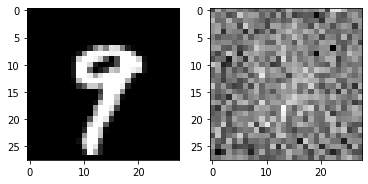

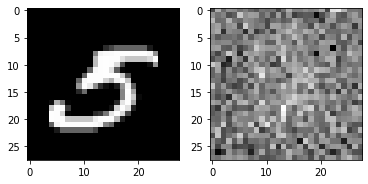

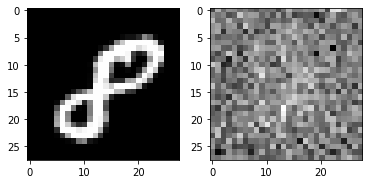

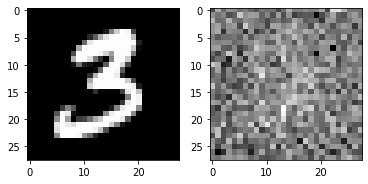

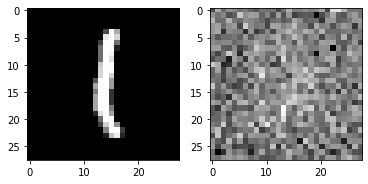

Mean: -0.044879006126152234, std: 0.4365727867031648
Validation KL loss: 5847.155673555071
Validation l2 loss: 1567922.0637729438
Total loss: 1573769.219446499
Mean: 0.0699073723651634, std: 0.5326197487982712
Validation KL loss: 10931.294550666678
Validation l2 loss: 1506096.2955553015
Total loss: 1517027.590105968
Mean: 0.035186504330518883, std: 0.37347090309942405
Validation KL loss: 34614.74595053347
Validation l2 loss: 1351020.1268324554
Total loss: 1385634.872782989
Mean: 0.012749429687205422, std: 0.23195854897222423
Validation KL loss: 43509.47520871595
Validation l2 loss: 1235055.9226520003
Total loss: 1278565.3978607163
Mean: -0.023125009681053257, std: 0.2291688285882372
Validation KL loss: 21301.96459574742
Validation l2 loss: 1189071.1520753745
Total loss: 1210373.116671122



Starting epoch:  1
Mean: -0.06682133723822674, std: 0.25763366035188784
Validation KL loss: 27548.384901013647
Validation l2 loss: 1179218.1279898754
Total loss: 1206766.512890889
Mean: -0.002517866

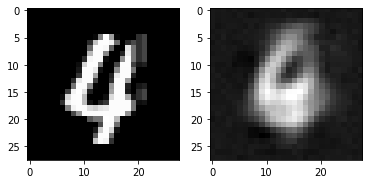

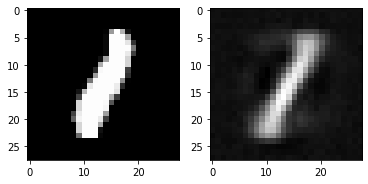

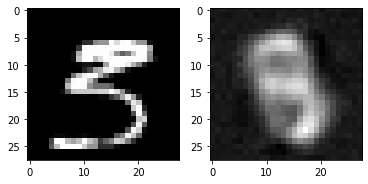

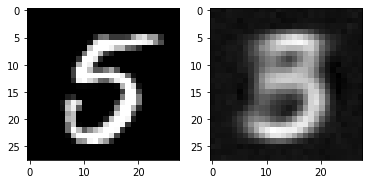

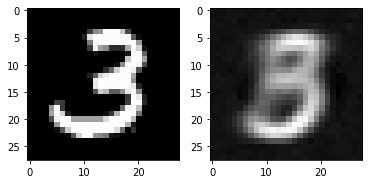

Mean: -0.021355660642537567, std: 0.2729416488279691
Validation KL loss: 25913.72726195558
Validation l2 loss: 1046766.738642598
Total loss: 1072680.4659045537
Mean: -8.645655018605028e-05, std: 0.2925483228495076
Validation KL loss: 23413.09610932024
Validation l2 loss: 1030417.0578285393
Total loss: 1053830.1539378595
Mean: -0.0020243910631617375, std: 0.2640758293313188
Validation KL loss: 26556.673716939025
Validation l2 loss: 1029813.7316771041
Total loss: 1056370.405394043
Mean: -0.04354212532395892, std: 0.2413127131259276
Validation KL loss: 30374.755362676013
Validation l2 loss: 1027606.675319511
Total loss: 1057981.430682187
Mean: 0.003957562733442611, std: 0.2390766664632434
Validation KL loss: 27696.725128350474
Validation l2 loss: 993884.2491211707
Total loss: 1021580.9742495212



Starting epoch:  3
Mean: -0.0037895704721239926, std: 0.2076213791778547
Validation KL loss: 29263.908130211523
Validation l2 loss: 987238.1919568955
Total loss: 1016502.100087107
Mean: 0.010988

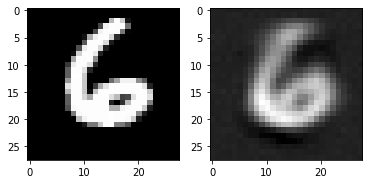

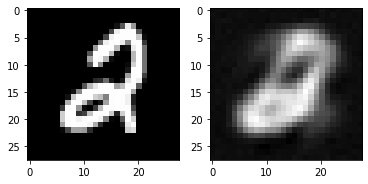

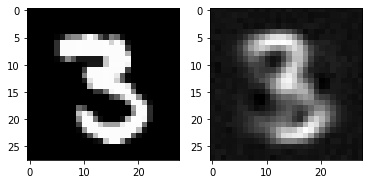

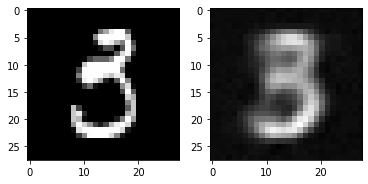

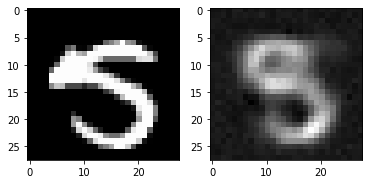

Mean: -0.06430497894536422, std: 0.19611550575787814
Validation KL loss: 30540.139857666996
Validation l2 loss: 930643.0236563147
Total loss: 961183.1635139817
Mean: -0.022837961257569605, std: 0.18682584523822826
Validation KL loss: 32471.17955920313
Validation l2 loss: 919171.7377107759
Total loss: 951642.917269979
Mean: 0.0235863150798222, std: 0.17931950627134666
Validation KL loss: 31654.775560333692
Validation l2 loss: 914826.2809342948
Total loss: 946481.0564946285
Mean: -0.03176964173560402, std: 0.17323548237332478
Validation KL loss: 34114.42059860283
Validation l2 loss: 900007.466207953
Total loss: 934121.8868065559
Mean: 0.014655172676754986, std: 0.17791376522240773
Validation KL loss: 32363.592098527228
Validation l2 loss: 886740.0415138323
Total loss: 919103.6336123595



Starting epoch:  5
Mean: -0.002772945076492617, std: 0.17286477898700342
Validation KL loss: 33380.14155767172
Validation l2 loss: 878728.6972428988
Total loss: 912108.8388005705
Mean: -0.04802569713698

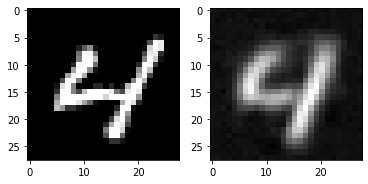

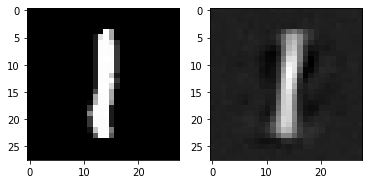

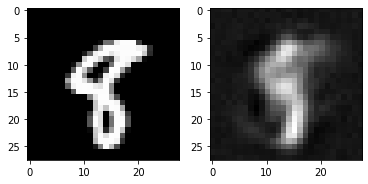

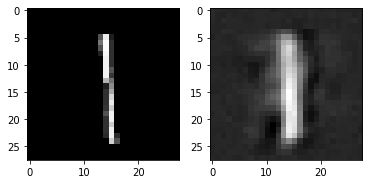

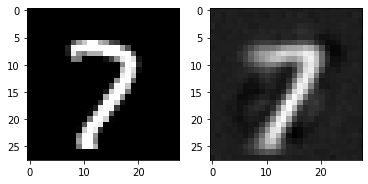

Mean: -0.062262323711057915, std: 0.17141198235662147
Validation KL loss: 34613.46102755244
Validation l2 loss: 873135.7978723163
Total loss: 907749.2588998688
Mean: 0.005239756652084169, std: 0.16976854839066216
Validation KL loss: 33057.46481909558
Validation l2 loss: 847828.9304913711
Total loss: 880886.3953104666
Mean: 0.006733923395217786, std: 0.17042899830921526
Validation KL loss: 32864.26951347555
Validation l2 loss: 845250.2021440491
Total loss: 878114.4716575247
Mean: 0.0157619241636372, std: 0.16761082095087818
Validation KL loss: 34642.217842378566
Validation l2 loss: 847292.7376366296
Total loss: 881934.9554790081
Mean: 0.011824423018379882, std: 0.16818628862149895
Validation KL loss: 32297.30999525685
Validation l2 loss: 836289.0705735935
Total loss: 868586.3805688503



Starting epoch:  7
Mean: -0.014797716859441491, std: 0.16786418524363408
Validation KL loss: 32850.567667997515
Validation l2 loss: 844219.8039714787
Total loss: 877070.3716394763
Mean: 0.02086261903731

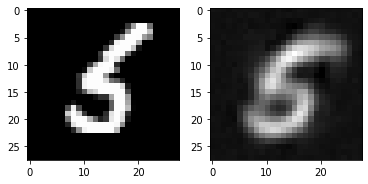

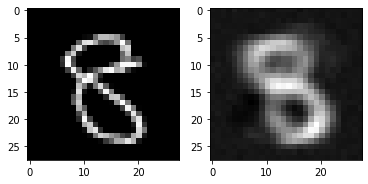

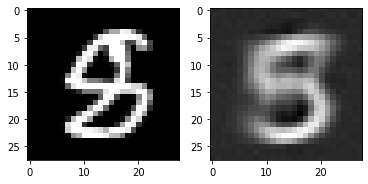

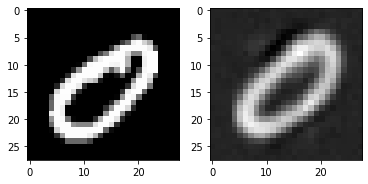

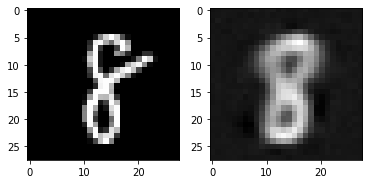

Mean: 0.01792320859936884, std: 0.1716676838170533
Validation KL loss: 34223.37032286602
Validation l2 loss: 823145.0679915514
Total loss: 857368.4383144174
Mean: -0.0053745980481383305, std: 0.1566500198997954
Validation KL loss: 34981.978401794986
Validation l2 loss: 825085.0428258756
Total loss: 860067.0212276706
Mean: 0.0015377373014958612, std: 0.16365107490788408
Validation KL loss: 35110.501240805315
Validation l2 loss: 826762.7463572958
Total loss: 861873.2475981012
Mean: -0.013065609168454543, std: 0.16227262205694362
Validation KL loss: 35622.14921563767
Validation l2 loss: 830054.7362288923
Total loss: 865676.88544453
Mean: 0.004451198070669069, std: 0.15630984318620686
Validation KL loss: 32360.42200315826
Validation l2 loss: 820958.4510332971
Total loss: 853318.8730364554



Starting epoch:  9
Mean: 0.012578848033588318, std: 0.16813180826497864
Validation KL loss: 34398.49168644124
Validation l2 loss: 820581.7834501875
Total loss: 854980.2751366288
Mean: 0.000516615744791

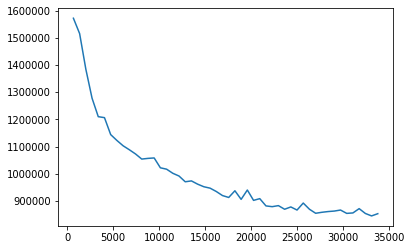

In [10]:
encode = EncodeModel([785,100,50,5], False, True)
decode = DecodeModel([5,50, 100, 785],False, True)
val_loss = train_mnist(encode, decode, 10)
utils.plot_loss(val_loss, "Validation loss")

## Sampling
Sampling is not really possible in the simple auto encoder as it is not stochastic in nature. The see the notebook on variational auto encoder instead.

In [20]:
def sampling(encoder, decoder):
    X_train, Y_train, X_val, Y_val, X_test, Y_test = utils.load_full_mnist(0.2)
    mean = np.mean(X_train)
    std = np.std(X_train)
    X_val = pre_process_images(X_val, mean, std)
    z = encoder.forward(X_val[1,:].reshape(1,-1))
    epsilon = np.ones(5)
    #epsilon[0] = -2.
    print(encoder.mean, encoder.std)
    for i in range(0,5):
        epsilon = np.random.normal(0,2,(5))
        z = encoder.mean + epsilon*encoder.std
        print(z)
        y = decoder.forward(z)
        plt.imshow(y[0,1:].reshape(28,28), cmap = "gray")
        plt.show()

Train shape: X: (48000, 784), Y: (48000, 1)
Validation shape: X: (12000, 784), Y: (12000, 1)
Test shape: X: (10000, 784), Y: (10000, 1)
[[-0.1330991   0.0619513  -2.7779025   2.95595635 -0.46595869]] [[0.11310441 1.17017976 0.13275862 0.12507938 0.41037948]]
[[ 0.01319152 -2.73074986 -2.29763271  1.73098039  2.81374162]]


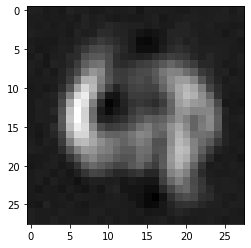

[[ 1.20471487  5.3006292  -2.15755687  1.71261553  8.95249838]]


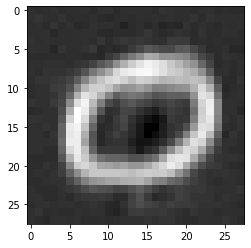

[[-0.38292814  5.60680233 -2.20105548  0.62206401  3.65476707]]


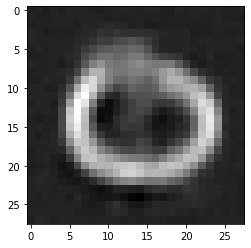

[[-0.07386305  7.98620182 -2.55858991  2.88062026 -2.11113685]]


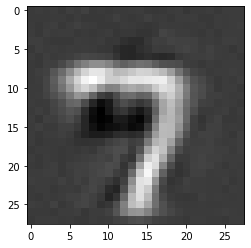

[[-1.92035603 11.23620762 -0.63526604  2.72614137 -5.29941476]]


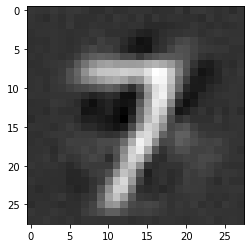

In [21]:
sampling(encode,decode)